In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [2]:
def visualize_embeddings_tSNE(emb_matrix, word_types):
    print("Running tSNE on", emb_matrix.shape, "-dim data")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
    tsne_results = tsne.fit_transform(emb_matrix)
    print('t-SNE done!')
    df_tsne = {'word_type': word_types}
    df_tsne['ax1'] = tsne_results[:, 0]
    df_tsne['ax2'] = tsne_results[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_tsne,
                     x='ax1',
                     y='ax2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_layout(legend=dict(font=dict(size=10)))
    fig.show()

In [3]:
def visualize_embeddings_PCA(emb_matrix, word_types):
    print("Running PCA on", emb_matrix.shape, "-dim matrix")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(emb_matrix)
    df_pca = {'word_type': word_types}
    df_pca['PC1'] = pca_result[:, 0]
    df_pca['PC2'] = pca_result[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_pca,
                     x='PC1',
                     y='PC2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.show()

In [4]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [5]:
tasks = ['P', 'PC', 'PCT', 'PT']

df = pd.read_csv("concreteness_norms_input_embs_multimodal.csv")

df["task"] = [m.split("/")[0] for m in df.model.tolist()]
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning", value="PC", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning-translation", value="PCT", inplace=True)
df["task"].replace(to_replace="paraphrase-translation", value="PT", inplace=True)
df.task.value_counts()

task
P      80000
PC     80000
PCT    80000
PT     80000
Name: count, dtype: int64

In [ ]:
def compute_purity(data):
    emb_matrix = np.array(data.iloc[:,:512])
    true_labels = data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

def compute_purity_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

task_purity = {'task':[], 
               'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity['purity'].extend(model_purity.tolist())
    task_purity['task'].extend([task]*len(model_purity))

Task: P
mean: 0.7668375000000001
std: 0.03304705027761604
Task: PC


<AxesSubplot:xlabel='task', ylabel='purity'>

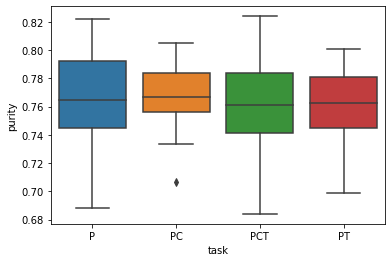

In [12]:
import seaborn as sns
task_purity = pd.DataFrame.from_dict(task_purity)
sns.boxplot(data=task_purity, x="task", y="purity")

In [13]:
from scipy.stats import kruskal
P_purity = task_purity[task_purity.task == 'P'].purity.to_list()
PC_purity = task_purity[task_purity.task == 'PC'].purity.to_list()
PCT_purity = task_purity[task_purity.task == 'PCT'].purity.to_list()
PT_purity = task_purity[task_purity.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PT:", kruskal(PC_purity, PCT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.003913046026859045, pvalue=0.950121385913367)
P vs PCT: KruskalResult(statistic=0.800899042349974, pvalue=0.3708247065189253)
P vs PT: KruskalResult(statistic=0.8623969872809084, pvalue=0.3530687800080681)
PC vs PT: KruskalResult(statistic=1.0405167159000308, pvalue=0.30770132791656674)
PC vs PCT: KruskalResult(statistic=1.0405167159000308, pvalue=0.30770132791656674)
PCT vs PT: KruskalResult(statistic=0.028359472987084522, pvalue=0.8662664756925953)


In [14]:
def compute_silhouette_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(word_type_counts['abstract'])
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    return metrics.silhouette_score(emb_matrix, true_labels)

task_sil = {'task':[], 
               'sil':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_sil = task_models.groupby("model").apply(lambda x: compute_silhouette_balance_data(x))
    print('mean:', model_sil.mean())
    print('std:', model_sil.std())
    task_sil['sil'].extend(model_sil.tolist())
    task_sil['task'].extend([task]*len(model_sil))

Task: P
mean: 0.025118189804249513
std: 0.004429409367068915
Task: PC
mean: 0.02648950538524757
std: 0.0036635414599303687
Task: PCT
mean: 0.02478494553597874
std: 0.004930167935975842
Task: PT
mean: 0.02654065351162014
std: 0.004266023370106443


In [15]:
from scipy.stats import kruskal
task_sil = pd.DataFrame.from_dict(task_sil)
P_sil = task_sil[task_sil.task == 'P'].sil.to_list()
PC_sil = task_sil[task_sil.task == 'PC'].sil.to_list()
PCT_sil = task_sil[task_sil.task == 'PCT'].sil.to_list()
PT_sil = task_sil[task_sil.task == 'PT'].sil.to_list()
print("P vs PC:", kruskal(P_sil, PC_sil))
print("P vs PCT:", kruskal(P_sil, PCT_sil))
print("P vs PT:", kruskal(P_sil, PT_sil))
print("PC vs PCT:", kruskal(PC_sil, PCT_sil))
print("PC vs PT:", kruskal(PC_sil, PT_sil))
print("PCT vs PT:", kruskal(PCT_sil, PT_sil))

P vs PC: KruskalResult(statistic=2.490370370370357, pvalue=0.11454476620511844)
P vs PCT: KruskalResult(statistic=0.01120370370369983, pvalue=0.9157033097364263)
P vs PT: KruskalResult(statistic=2.933703703703742, pvalue=0.08674827300826901)
PC vs PCT: KruskalResult(statistic=1.3781481481481705, pvalue=0.24041683705469835)
PC vs PT: KruskalResult(statistic=0.10083333333335531, pvalue=0.7508318840890909)
PCT vs PT: KruskalResult(statistic=2.167500000000018, pvalue=0.14095521914436548)


In [17]:
# Affinity propagation clustering
def compute_purity_balance_data_aff_prop(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    aff_prop = AffinityPropagation().fit(emb_matrix)
    y_pred = aff_prop.labels_
    #print('emb_matrix:', emb_matrix.shape)
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_aff_prop = {'task':[], 
                        'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_aff_prop(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_aff_prop['purity'].extend(model_purity.tolist())
    task_purity_aff_prop['task'].extend([task]*len(model_purity))

Task: P


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.7591125
std: 0.022695726328755023
Task: PC


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.7618375000000001
std: 0.018094972917133485
Task: PCT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propaga

mean: 0.7596375
std: 0.01703088728736327
Task: PT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propaga

mean: 0.7655624999999999
std: 0.017497321223547333


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [18]:
from scipy.stats import kruskal
task_purity_aff_prop = pd.DataFrame.from_dict(task_purity_aff_prop)
P_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'P'].purity.to_list()
PC_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PC'].purity.to_list()
PCT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PCT'].purity.to_list()
PT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.26514123730681477, pvalue=0.6066098534491037)
P vs PCT: KruskalResult(statistic=0.00037060927699448864, pvalue=0.9846407015381468)
P vs PT: KruskalResult(statistic=2.1965695527287443, pvalue=0.1383182534140558)
PC vs PCT: KruskalResult(statistic=0.5005486031291638, pvalue=0.4792591698804487)
PC vs PT: KruskalResult(statistic=0.7421247214729868, pvalue=0.388981103041697)
PCT vs PT: KruskalResult(statistic=4.262006648374875, pvalue=0.038973857568944545)


In [6]:
# Agglomerative (hierarchical) clustering
def compute_purity_balance_data_agglomerative(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    agg = AgglomerativeClustering(n_clusters=None,
                                  metric='cosine',
                                  linkage='average',
                                 distance_threshold=0.5).fit(emb_matrix)
    y_pred = agg.labels_
    #print('n_clusters:', len(Counter(y_pred)))
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_agg = {'task':[], 
                   'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_agglomerative(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_agg['purity'].extend(model_purity.tolist())
    task_purity_agg['task'].extend([task]*len(model_purity))

Task: P
mean: 0.9999125000000001
std: 0.0002503203076265549
Task: PC
mean: 0.999925
std: 0.00018081014266987477
Task: PCT
mean: 0.9999125
std: 0.00019240382212737516
Task: PT
mean: 0.9998625000000001
std: 0.0003200060095589398


In [8]:
from scipy.stats import kruskal
task_purity_agg = pd.DataFrame.from_dict(task_purity_agg)
P_purity = task_purity_agg[task_purity_agg.task == 'P'].purity.to_list()
PC_purity = task_purity_agg[task_purity_agg.task == 'PC'].purity.to_list()
PCT_purity = task_purity_agg[task_purity_agg.task == 'PCT'].purity.to_list()
PT_purity = task_purity_agg[task_purity_agg.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.05083554942704364, pvalue=0.8216156818385859)
P vs PCT: KruskalResult(statistic=0.2626098901099474, pvalue=0.6083327684108404)
P vs PT: KruskalResult(statistic=0.7575712656785131, pvalue=0.384089659160188)
PC vs PCT: KruskalResult(statistic=0.0907003444316903, pvalue=0.7632886936791208)
PC vs PT: KruskalResult(statistic=0.45022489159412504, pvalue=0.5022281762806404)
PCT vs PT: KruskalResult(statistic=0.1469308092663036, pvalue=0.7014858124867243)
